In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales.xlsx'
data = pd.ExcelFile(file_path)

# Display the sheet names to understand the structure of the file
data.sheet_names

['Sheet1']

In [ ]:
# Load the data from the first sheet
df = data.parse('Sheet1')

# Display the first few rows and the basic structure of the dataset
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_details_id   48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_id           48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
 12  customer_name      48620 non-null  object        
 13  customer_gender    48620 non-null  object        
 14  custom

(   order_details_id  order_id       pizza_id  quantity order_date order_time  \
 0                 1         1     hawaiian_m         1 2015-01-01   11:38:36   
 1                 2         2  classic_dlx_m         1 2015-01-01   11:57:40   
 2                 3         2  five_cheese_l         1 2015-01-01   11:57:40   
 3                 4         2    ital_supr_l         1 2015-01-01   11:57:40   
 4                 5         2     mexicana_m         1 2015-01-01   11:57:40   
 
    unit_price  total_price pizza_size pizza_category  ...   customer_name  \
 0       13.25        13.25          M        Classic  ...   Hannah Miller   
 1       16.00        16.00          M        Classic  ...   Fiona Johnson   
 2       18.50        18.50          L         Veggie  ...    Edward Brown   
 3       20.75        20.75          L        Supreme  ...    Diana Garcia   
 4       16.00        16.00          M         Veggie  ...  Charlie Miller   
 
   customer_gender            customer_dob

# 1.1. Sales Analysis by Date and Pizza Type

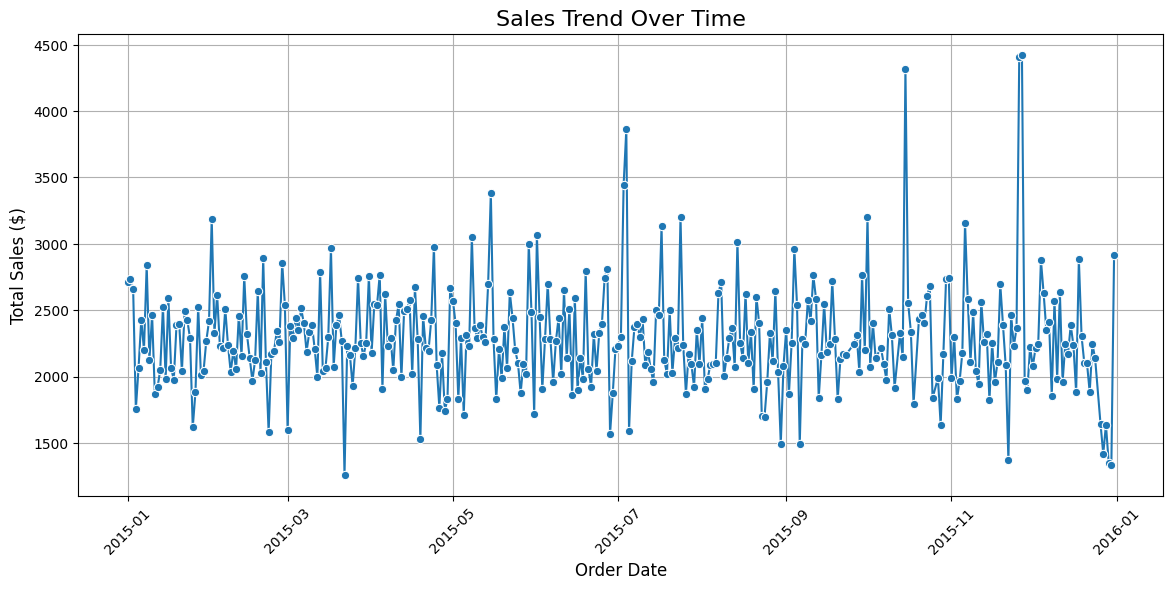

<ipython-input-12-9b529cc538bf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_category.index, y=sales_by_category.values, palette='viridis')


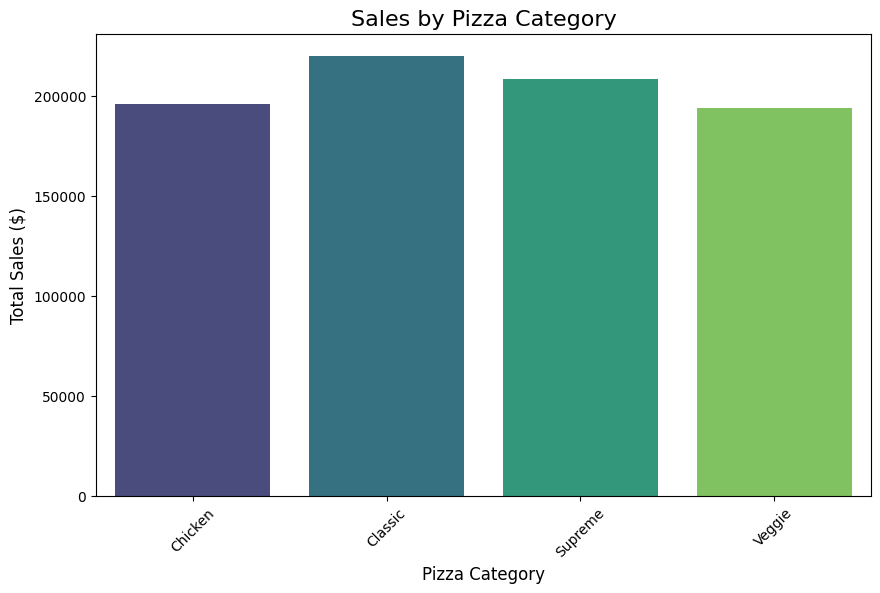

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping sales data by date and category for analysis
sales_by_date = df.groupby('order_date')['total_price'].sum()
sales_by_category = df.groupby('pizza_category')['total_price'].sum()

# Plot sales trend over time
plt.figure(figsize=(14, 6))
sns.lineplot(x=sales_by_date.index, y=sales_by_date.values, marker='o')
plt.title('Sales Trend Over Time', fontsize=16)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot sales by pizza category
plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_category.index, y=sales_by_category.values, palette='viridis')
plt.title('Sales by Pizza Category', fontsize=16)
plt.xlabel('Pizza Category', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


Looking at the charts we can see:
1. Sales trends over time:
- The chart shows that sales fluctuate between $1,500-and-$4,500 per day.
- There are spikes in sales on certain special days, which could be holidays or promotions.
2. Sales by pizza type:
- Classic and Supreme are the two best-selling categories.
- Chicken and Veggie have lower sales, indicating that marketing may need to be improved or menu adjustments may need to be considered.

# I/ Linear Regression with Prophet

Dự báo số lượng từng item pizza bán được trong năm 2016 so với năm 2015.

<ipython-input-13-b02968751e5f>:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'ds': pd.date_range(start='2015-01-01', periods=12, freq='M'),
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hf26ohn/w306vngi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1hf26ohn/t67drjzi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62126', 'data', 'file=/tmp/tmp1hf26ohn/w306vngi.json', 'init=/tmp/tmp1hf26ohn/t67drjzi.json', 'o

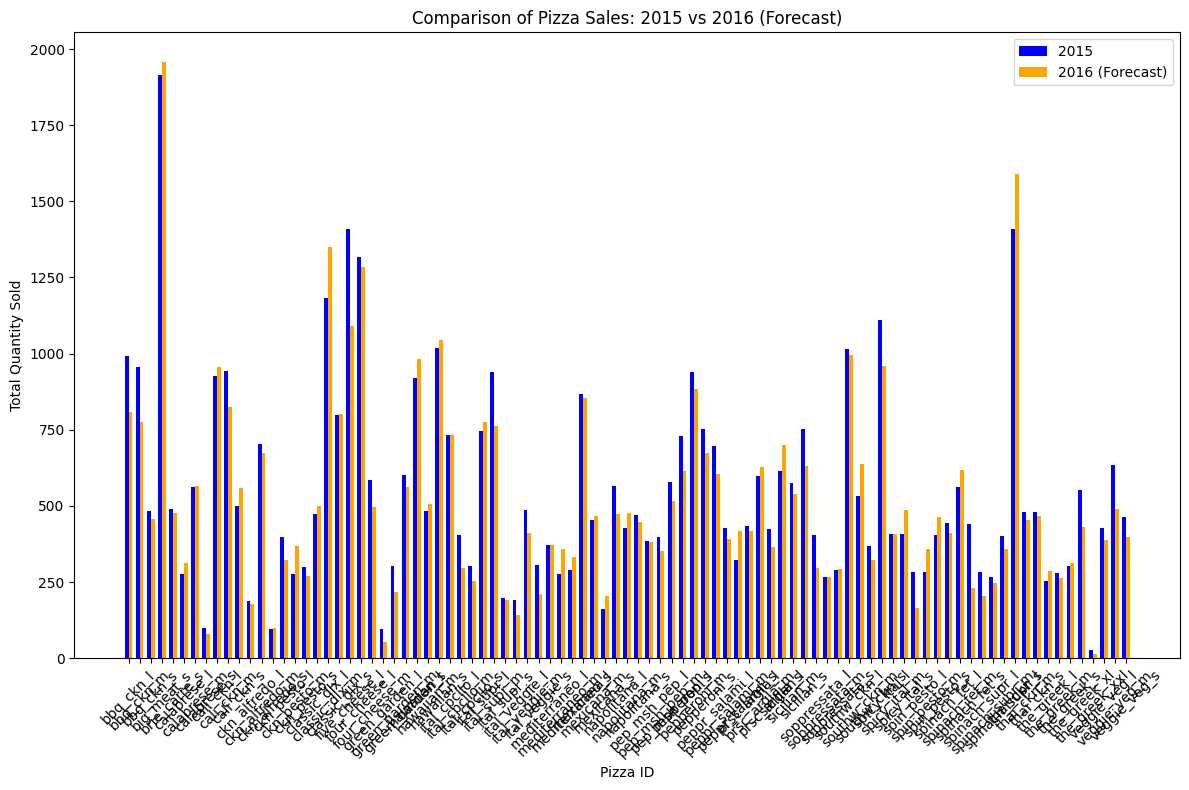

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
from prophet import Prophet

# Đọc dữ liệu từ file Excel
file_path = '/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales (1).xlsx'
df = pd.read_excel(file_path)

# Tiền xử lý dữ liệu
df['order_date'] = pd.to_datetime(df['order_date'])
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month

# Lọc dữ liệu năm 2015
df_2015 = df[df['year'] == 2015]

# Tổng hợp số lượng bán theo loại pizza và theo tháng
monthly_sales_2015 = df_2015.groupby(['pizza_id', 'month'])['quantity'].sum().unstack(fill_value=0)

# Prepare data for Prophet
forecast_2016 = {}
for pizza_id in monthly_sales_2015.index:
    sales_data = monthly_sales_2015.loc[pizza_id]
    df_prophet = pd.DataFrame({
        'ds': pd.date_range(start='2015-01-01', periods=12, freq='M'),
        'y': sales_data
    })

    # Fit Prophet model
    model = Prophet()
    model.fit(df_prophet)

    # Forecast for 12 months in 2016
    future = pd.DataFrame({'ds': pd.date_range(start='2016-01-01', periods=12, freq='M')})
    forecast = model.predict(future)

    # Extract forecasted values
    forecast_2016[pizza_id] = forecast['yhat'].values

# Create DataFrame for forecasts
forecast_2016_df = pd.DataFrame(forecast_2016, index=range(1, 13)).T
forecast_2016_df.columns = [f'Month_{i}' for i in range(1, 13)]

# Tính tổng số lượng theo năm
total_sales_2015 = monthly_sales_2015.sum(axis=1)
total_sales_2016 = forecast_2016_df.sum(axis=1)

# Biểu diễn dữ liệu trên biểu đồ
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(total_sales_2015))

plt.bar(index, total_sales_2015, bar_width, label='2015', color='blue')
plt.bar(index + bar_width, total_sales_2016, bar_width, label='2016 (Forecast)', color='orange')

plt.xlabel('Pizza ID')
plt.ylabel('Total Quantity Sold')
plt.title('Comparison of Pizza Sales: 2015 vs 2016 (Forecast)')
plt.xticks(index + bar_width / 2, total_sales_2015.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

Dự báo doanh thu của từng pizza dựa trên số lượng từng item pizza bán được trong năm 2016 so với năm 2015.

<ipython-input-34-4d4fd00a8d36>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_2015 = sales_2015.groupby('pizza_name').apply(
<ipython-input-34-4d4fd00a8d36>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'ds': pd.date_range(start='2015-01-01', periods=12, freq='M'),
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations.

<Figure size 1500x800 with 0 Axes>

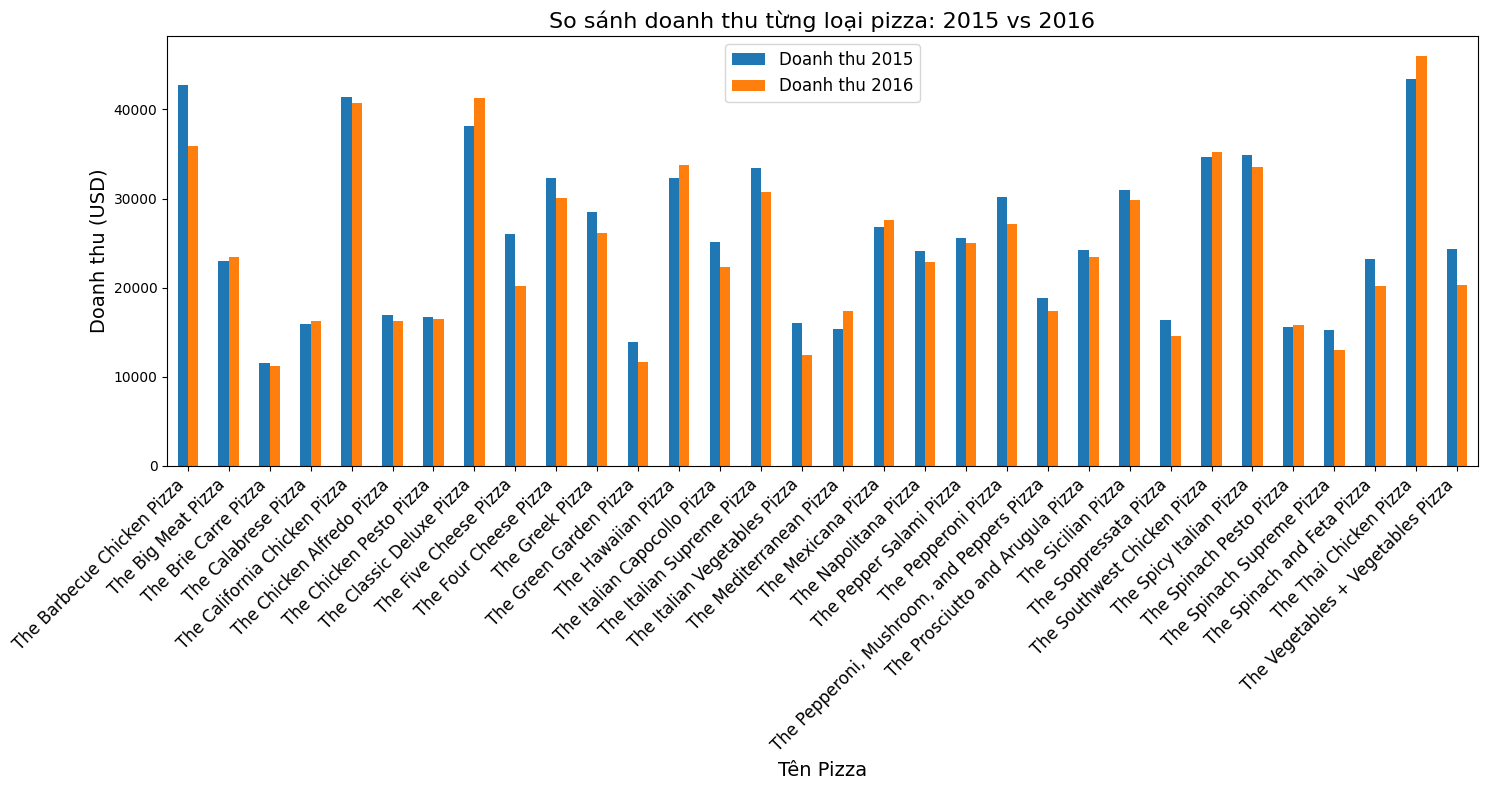

Bảng so sánh doanh thu 2015 và 2016:
                                            revenue_2015  revenue_2016  \
The Classic Deluxe Pizza                        38180.50  41275.689485   
The Thai Chicken Pizza                          43434.25  45957.439765   
The Mediterranean Pizza                         15360.50  17372.453559   
The Hawaiian Pizza                              32273.25  33728.463580   
The Mexicana Pizza                              26780.75  27552.434400   
The Southwest Chicken Pizza                     34705.75  35274.298686   
The Big Meat Pizza                              22968.00  23483.976636   
The Calabrese Pizza                             15934.25  16228.436481   
The Spinach Pesto Pizza                         15596.00  15848.395027   
The Chicken Pesto Pizza                         16701.75  16484.407158   
The Brie Carre Pizza                            11588.50  11254.415630   
The Pepper Salami Pizza                         25529.00  24958.243429   
T

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Đọc dữ liệu từ file đã cho (Processed_Pizza_Sales.xlsx)
data = pd.read_excel('/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales (1).xlsx')

# Bước 1: Tiền xử lý dữ liệu
data['order_date'] = pd.to_datetime(data['order_date'])
data['year'] = data['order_date'].dt.year
data['month'] = data['order_date'].dt.month

# Tính doanh thu năm 2015
sales_2015 = data[data['year'] == 2015]
revenue_2015 = sales_2015.groupby('pizza_name').apply(
    lambda x: (x['quantity'] * x['unit_price']).sum()
).rename('revenue_2015')

# Tổng hợp số lượng bán theo tháng trong năm 2015
monthly_sales_2015 = sales_2015.groupby(['pizza_name', 'month'])['quantity'].sum().unstack(fill_value=0)

# Bước 2: Dự báo số lượng bán năm 2016 với Prophet
forecast_2016 = {}
for pizza_name in monthly_sales_2015.index:
    sales_data = monthly_sales_2015.loc[pizza_name]
    df_prophet = pd.DataFrame({
        'ds': pd.date_range(start='2015-01-01', periods=12, freq='M'),
        'y': sales_data.values
    })

    model = Prophet()
    model.fit(df_prophet)

    future = pd.DataFrame({'ds': pd.date_range(start='2016-01-01', periods=12, freq='M')})
    forecast = model.predict(future)

    # Lưu số lượng dự báo cho từng pizza
    forecast_2016[pizza_name] = forecast['yhat'].values

# Tổng số lượng bán dự báo năm 2016
forecasted_quantities_2016 = pd.DataFrame(forecast_2016).sum(axis=0)

# Giá đơn vị trung bình năm 2015
unit_prices = sales_2015.groupby('pizza_name')['unit_price'].mean()

# Doanh thu dự báo năm 2016
revenue_2016 = (forecasted_quantities_2016 * unit_prices).rename('revenue_2016')

# Gộp doanh thu 2015 và 2016 vào một DataFrame
revenue_comparison = pd.concat([revenue_2015, revenue_2016], axis=1)
revenue_comparison['revenue_change'] = revenue_comparison['revenue_2016'] - revenue_comparison['revenue_2015']

# Bước 3: Trực quan hóa doanh thu năm 2015 và 2016
plt.figure(figsize=(15, 8))

# Vẽ biểu đồ cột
revenue_comparison[['revenue_2015', 'revenue_2016']].plot(kind='bar', figsize=(15, 8))

# Tùy chỉnh biểu đồ
plt.title('So sánh doanh thu từng loại pizza: 2015 vs 2016', fontsize=16)
plt.xlabel('Tên Pizza', fontsize=14)
plt.ylabel('Doanh thu (USD)', fontsize=14)
plt.legend(['Doanh thu 2015', 'Doanh thu 2016'], fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

# Bước 4: In ra bảng so sánh doanh thu
print("Bảng so sánh doanh thu 2015 và 2016:")
print(revenue_comparison.sort_values(by='revenue_change', ascending=False))


# II/ K-Means

1. Phân cụm khách hàng để tìm nhóm khách hàng tiềm năng để tập trung chiến lược marketing.

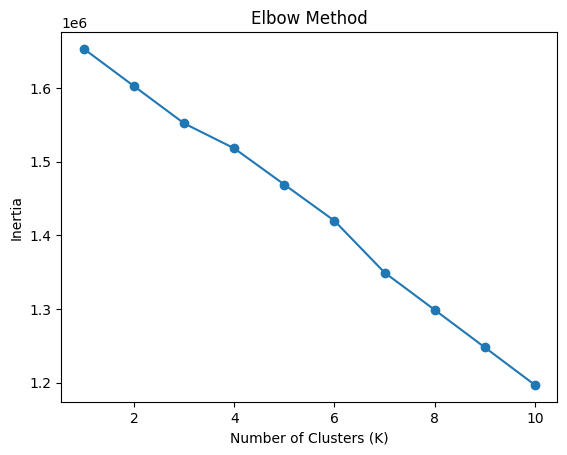

Silhouette Score: 0.041683805050199536
Kết quả phân cụm (trung bình các cột số):
         order_details_id      order_id  quantity  unit_price  total_price  \
Cluster                                                                      
0            24530.364456  10798.950663  1.016976   18.080504    18.411538   
1            24305.029230  10699.058082  1.019383   16.408641    16.729166   
2            24219.208649  10660.920000  1.028108   16.951946    17.440919   

         customer_gender  employee_id  revenue_per_pizza  order_hour  \
Cluster                                                                
0               0.483103  5472.041910          18.080504   15.890716   
1               0.501632  5480.872786          16.408641   15.915985   
2               0.499590  5522.301622          16.951946   15.831892   

               age  
Cluster             
0        46.597347  
1        46.509502  
2        46.425946  
Pizza phổ biến nhất trong mỗi cluster:
Cluster
0    The Southw

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Đọc dữ liệu từ file Excel
df = pd.read_excel('/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales.xlsx')

# Tiền xử lý dữ liệu
# Tạo cột độ tuổi từ ngày sinh
df['customer_dob'] = pd.to_datetime(df['customer_dob'])
df['age'] = (pd.to_datetime('today') - df['customer_dob']).dt.days // 365

# Mã hóa giới tính
df['customer_gender'] = df['customer_gender'].map({'Male': 0, 'Female': 1})

# Xử lý pizza_name (One-hot encoding)
# Biến pizza_name (tên các loại pizza) được chuyển thành nhiều cột nhị phân (binary columns), mỗi cột đại diện cho một loại pizza.
pizza_columns = pd.get_dummies(df['pizza_name'], prefix='pizza')

# Kết hợp các đặc trưng vào một DataFrame
features = pd.concat([df[['age', 'customer_gender']], pizza_columns], axis=1)

# Xử lý giá trị thiếu (NaN) - Thay thế NaN bằng giá trị trung bình của cột
# Lọc ra các cột số
numeric_columns = features.select_dtypes(include=['float64', 'int64']).columns
features[numeric_columns] = features[numeric_columns].fillna(features[numeric_columns].mean())

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Xác định số nhóm K tối ưu bằng Elbow Method
# inertia đo độ nén của các điểm dữ liệu trong từng cụm, là tổng bình phương khoảng cách từ các điểm đến tâm cụm. Giá trị nhỏ hơn nghĩa là cụm tốt hơn.
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Vẽ đồ thị Elbow Method để chọn K tối ưu
# Đồ thị hiển thị mối quan hệ giữa số lượng cụm (K) và inertia. Từ đồ thị, "khuỷu tay" (elbow) xuất hiện ở K = 3, do đó K = 3 được chọn.
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Chọn số nhóm K = 3 (ví dụ)
# Dữ liệu được phân thành 3 cụm, và kết quả cụm của mỗi dòng được lưu trong cột Cluster.
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Đánh giá mô hình phân cụm
# Silhouette Score đo độ tách biệt giữa các cụm (càng cao càng tốt). Ở đây, điểm số là 0.041, cho thấy việc phân cụm không rõ ràng lắm.
sil_score = silhouette_score(scaled_features, df['Cluster'])
print(f'Silhouette Score: {sil_score}')

# Xem kết quả phân cụm
# Chỉ chọn các cột số để tính mean
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Thực hiện groupby và tính trung bình trên cột số
# Các giá trị trung bình của các đặc trưng số (như age, customer_gender,...) được tính theo từng cụm. Kết quả trong hình hiển thị rõ đặc trưng của mỗi cụm:
# + Cụm 0, 1, và 2 có tuổi trung bình lần lượt là 46.59, 46.59, và 46.42.
# + Các cụm cũng có sự khác biệt nhẹ về doanh thu trên mỗi chiếc pizza (revenue_per_pizza), giờ đặt hàng (order_hour),...
grouped_data = df.groupby('Cluster')[numeric_columns].mean()
print("Kết quả phân cụm (trung bình các cột số):")
print(grouped_data)

# Nếu cần thêm thông tin khác (như pizza phổ biến nhất)
# Pizza phổ biến nhất trong từng cụm được xác định:
# + Cụm 0: The Southwest Chicken Pizza.
# + Cụm 1: The Classic Deluxe Pizza.
# + Cụm 2: The Four Cheese Pizza.
popular_pizza = df.groupby('Cluster')['pizza_name'].agg(lambda x: x.mode()[0])
print("Pizza phổ biến nhất trong mỗi cluster:")
print(popular_pizza)

Kết quả và ý nghĩa:
- Đồ thị Elbow Method: Hiển thị số cụm tối ưu là 3 (K = 3).
- Silhouette Score: Chỉ ra rằng việc phân cụm không hoàn toàn tách biệt rõ ràng.

Phân tích cụm: Các cụm khác nhau chủ yếu ở đặc trưng như độ tuổi, doanh thu trên mỗi chiếc pizza, và loại pizza phổ biến nhất.
* Lưu ý: Điểm Silhouette thấp có thể là do dữ liệu không có sự phân cụm tự nhiên hoặc cần thêm các đặc trưng để cải thiện kết quả.

# III/ Phân tích thống kê đơn giản và phân tích ngôn ngữ tự nhiên (NLP) dựa trên thư viện TextBlob

2. Phân tích phản hồi khách hàng theo nền tảng (feedback_platform) và áp dụng phân tích cảm xúc (sentiment analysis) nếu phản hồi chứa nội dung văn bản để tối ưu hóa chiến lược marketing của nhà hàng

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk
nltk.download('punkt')  # Tải dữ liệu để xử lý văn bản

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Đọc dữ liệu từ file Excel
df = pd.read_excel('/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales.xlsx')

# Kiểm tra thông tin cơ bản của dữ liệu
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_details_id   48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_id           48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
 12  customer_name      48620 non-null  object        
 13  customer_gender    48620 non-null  object        
 14  custom

In [ ]:
# Loại bỏ các dòng không có nội dung phản hồi hoặc nền tảng phản hồi
df = df.dropna(subset=['customer_feedback', 'feedback_platform'])

# Kiểm tra các giá trị unique trong cột feedback_platform
print(df['feedback_platform'].value_counts())

feedback_platform
Zomato             12253
Google Review      12212
Internal Survey    12150
Yelp               12005
Name: count, dtype: int64


Số lượng phản hồi theo nền tảng:
feedback_platform
Zomato             12253
Google Review      12212
Internal Survey    12150
Yelp               12005
Name: count, dtype: int64


<ipython-input-31-2106f70b743d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feedback_by_platform.index, y=feedback_by_platform.values, palette="viridis")


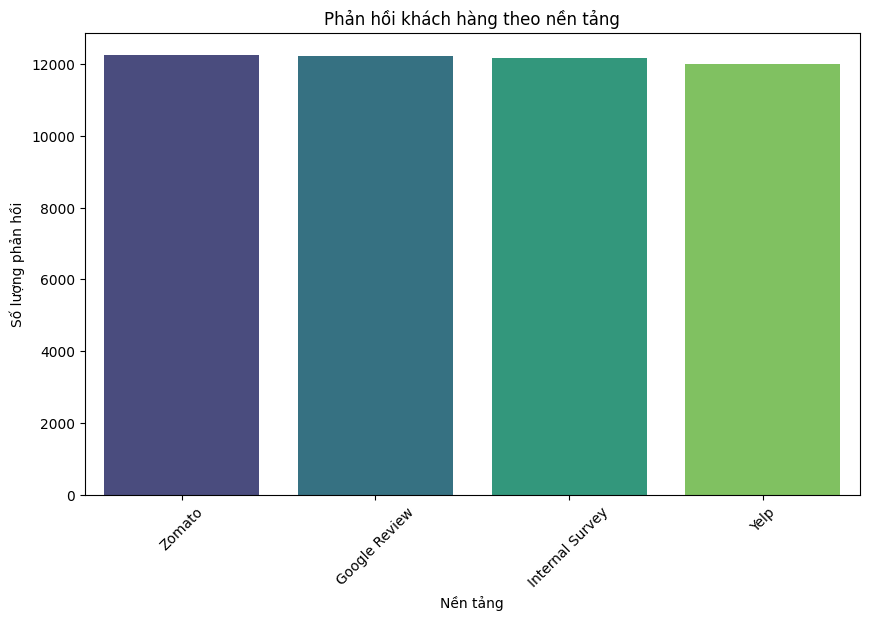

In [ ]:
# Đếm số lượng phản hồi theo nền tảng
feedback_by_platform = df['feedback_platform'].value_counts()

# Hiển thị kết quả
print("Số lượng phản hồi theo nền tảng:")
print(feedback_by_platform)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x=feedback_by_platform.index, y=feedback_by_platform.values, palette="viridis")
plt.title("Phản hồi khách hàng theo nền tảng")
plt.xlabel("Nền tảng")
plt.ylabel("Số lượng phản hồi")
plt.xticks(rotation=45)
plt.show()


Ý nghĩa: Biểu đồ này sẽ giúp xác định kênh nhận được nhiều phản hồi nhất (ví dụ: Zomato, Google Review).

Phân tích cảm xúc:
sentiment
Positive    30432
Negative    18188
Name: count, dtype: int64


<ipython-input-32-5fb909ab77b7>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")


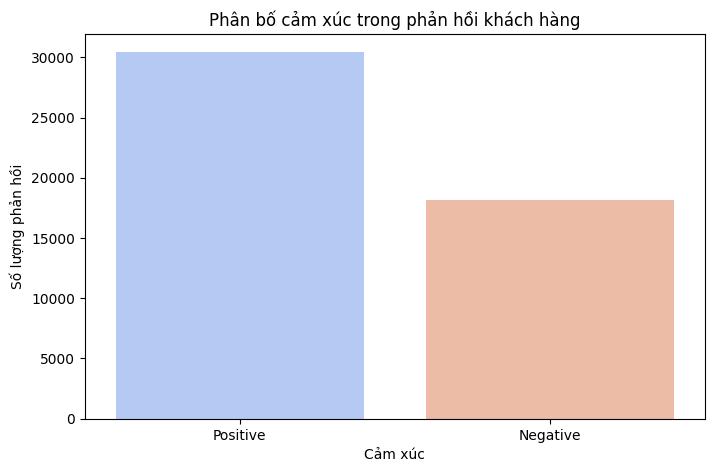

In [ ]:
# Hàm phân tích cảm xúc
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Thêm cột 'sentiment' vào DataFrame
df['sentiment'] = df['customer_feedback'].apply(analyze_sentiment)

# Đếm số lượng phản hồi theo cảm xúc
sentiment_counts = df['sentiment'].value_counts()

# Hiển thị kết quả
print("Phân tích cảm xúc:")
print(sentiment_counts)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Phân bố cảm xúc trong phản hồi khách hàng")
plt.xlabel("Cảm xúc")
plt.ylabel("Số lượng phản hồi")
plt.show()


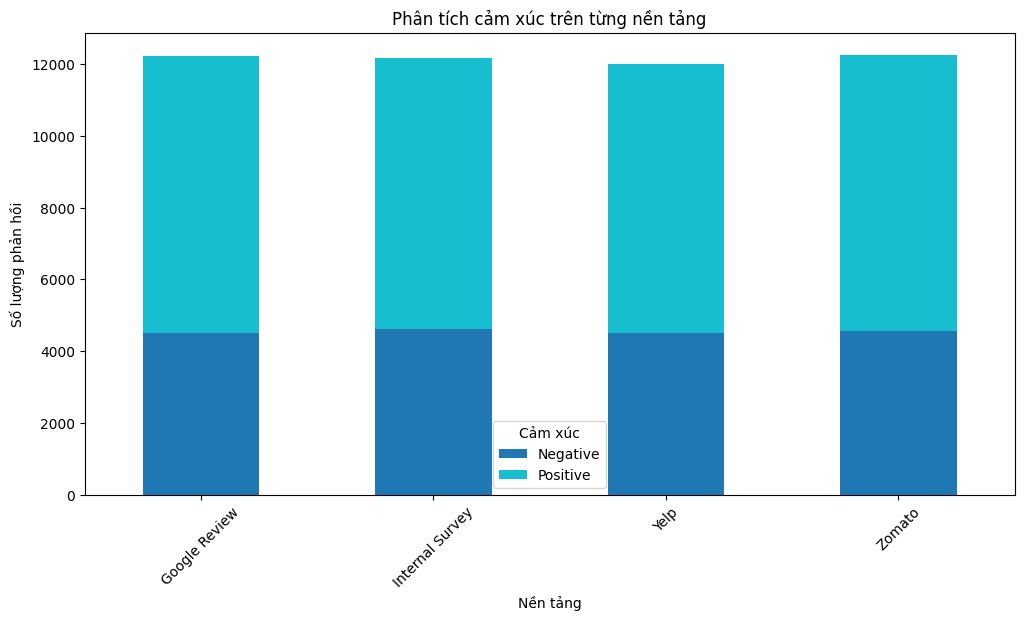

In [ ]:
# Nhóm dữ liệu theo nền tảng và cảm xúc
platform_sentiment = df.groupby(['feedback_platform', 'sentiment']).size().unstack()

# Vẽ biểu đồ
platform_sentiment.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
plt.title("Phân tích cảm xúc trên từng nền tảng")
plt.xlabel("Nền tảng")
plt.ylabel("Số lượng phản hồi")
plt.xticks(rotation=45)
plt.legend(title="Cảm xúc")
plt.show()


Ý nghĩa: Biểu đồ này sẽ cho biết trên từng nền tảng (ví dụ: Zomato, Internal Survey), cảm xúc tích cực, tiêu cực, hoặc trung lập chiếm ưu thế.

Từ các biểu đồ trên ta có thể thấy được là đánh giá tích cực nhiều hơn là tiêu cực của khách hàng ở mỗi nền tảng khác nhau. Tuy nhiên, theo số liệu thống kê có được thì nền tảng Zomato là có số lượng khách feedback là nhiều nhất đồng nghĩa chúng ta có thể đẩy mạnh quảng bá sản phẩm ở nền tảng đó nhiều hơn những nền tảng khác.

# IV/ ARIMA (bỏ)

1.2. Forecasting revenue for the next 30 days from the end of the last day of 2015 using ARIMA (AutoRegressive Integrated Moving Average) model

Mục tiêu chính là:

Dự báo doanh số bán hàng trong tương lai, qua đó:
Hỗ trợ lập kế hoạch kinh doanh.
Giúp quản lý nguồn lực hiệu quả (nguyên liệu, nhân sự).
Tạo cơ sở cho các chiến lược marketing và giá cả.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Prepare the time series data (sales by date)
time_series = sales_by_date

# "ADF Statistic": adf_test[0]: Lưu giá trị thống kê ADF (phần tử đầu tiên của tuple).
# "p-value": adf_test[1]: Lưu giá trị p-value (phần tử thứ hai của tuple). P-value cho biết xác suất để bác bỏ giả thuyết không (null hypothesis) rằng chuỗi thời gian có tính không ổn định.
# "Critical Values": adf_test[4]: Lưu các giá trị tới hạn (critical values) cho các mức ý nghĩa khác nhau (1%, 5%, 10%) (phần tử thứ năm của tuple).
# p-value < 0.05: Bác bỏ giả thuyết không (chuỗi ổn định).
# ADF Statistic nhỏ hơn các giá trị tới hạn: Bác bỏ giả thuyết không.
# Các giá trị tới hạn thường được cung cấp cho các mức ý nghĩa 1%, 5%, và 10% trong kết quả kiểm định.

# Step 2: Check for stationarity using the Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(time_series)
adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4],
}
print(adf_result)


# # Step 3: Differencing the data if non-stationary (if p-value > 0.05)
# if adf_test[1] > 0.05:
#     time_series_diff = time_series.diff().dropna()  # First differencing
# else:
#     time_series_diff = time_series  # Already stationary

# # Step 4: Fit an ARIMA model
# # Initial parameters for ARIMA (p=1, d=1, q=1 as starting point)
# arima_model = ARIMA(time_series, order=(1, 1, 1))
# arima_result = arima_model.fit()

# # Step 5: Forecast future sales (next 30 days)
# forecast_steps = 30
# forecast = arima_result.get_forecast(steps=forecast_steps)
# forecast_index = pd.date_range(start=time_series.index[-1] + pd.Timedelta(days=1),
#                                periods=forecast_steps, freq='D')
# forecast_values = forecast.predicted_mean
# forecast_conf_int = forecast.conf_int()

# # Display results
# forecast_values, forecast_conf_int



# Đảm bảo index là datetime và có tần suất
time_series.index = pd.to_datetime(time_series.index)
time_series = time_series.asfreq('D')  # Gắn tần suất là hàng ngày (Daily)

# Huấn luyện mô hình ARIMA
arima_model = ARIMA(time_series, order=(1, 1, 1))
arima_result = arima_model.fit()

# Dự báo 30 ngày tới
forecast_steps = 30
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=time_series.index[-1] + pd.Timedelta(days=1),
                               periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Chuyển kết quả về DataFrame để dễ xem
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_values.values,
    'Lower Bound': forecast_conf_int.iloc[:, 0].values,
    'Upper Bound': forecast_conf_int.iloc[:, 1].values
})

print(forecast_df)


{'ADF Statistic': -4.198002509215893, 'p-value': 0.000664048961462318, 'Critical Values': {'1%': -3.4497304638968043, '5%': -2.8700785273763487, '10%': -2.571319005190311}}
         Date     Forecast  Lower Bound  Upper Bound
0  2016-01-01  2357.491626  1566.712330  3148.270922
1  2016-01-02  2291.810941  1495.326336  3088.295545
2  2016-01-03  2284.086880  1487.493571  3080.680189
3  2016-01-04  2283.178529  1486.580178  3079.776880
4  2016-01-05  2283.071707  1486.472870  3079.670544
5  2016-01-06  2283.059145  1486.460252  3079.658037
6  2016-01-07  2283.057667  1486.458768  3079.656566
7  2016-01-08  2283.057494  1486.458594  3079.656393
8  2016-01-09  2283.057473  1486.458573  3079.656373
9  2016-01-10  2283.057471  1486.458571  3079.656370
10 2016-01-11  2283.057470  1486.458571  3079.656370
11 2016-01-12  2283.057470  1486.458571  3079.656370
12 2016-01-13  2283.057470  1486.458571  3079.656370
13 2016-01-14  2283.057470  1486.458571  3079.656370
14 2016-01-15  2283.057470  1486

Meaning of columns in forecast_df:
- Date: Forecast date (next 30 days from the last day of the original data).
- Forecast: Forecasted sales.
- Lower Bound: Lowest forecast value (95% confidence interval).
- Upper Bound: Highest forecast value (95% confidence interval).

In [ ]:
# Hiển thị 10 dòng đầu tiên của kết quả
print(forecast_df.head(10))

# Lưu dự báo vào file CSV
forecast_df.to_csv('sales_forecast_30_days.csv', index=False)
print("Kết quả đã lưu vào 'sales_forecast_30_days.csv'")

        Date     Forecast  Lower Bound  Upper Bound
0 2016-01-01  2357.491626  1566.712330  3148.270922
1 2016-01-02  2291.810941  1495.326336  3088.295545
2 2016-01-03  2284.086880  1487.493571  3080.680189
3 2016-01-04  2283.178529  1486.580178  3079.776880
4 2016-01-05  2283.071707  1486.472870  3079.670544
5 2016-01-06  2283.059145  1486.460252  3079.658037
6 2016-01-07  2283.057667  1486.458768  3079.656566
7 2016-01-08  2283.057494  1486.458594  3079.656393
8 2016-01-09  2283.057473  1486.458573  3079.656373
9 2016-01-10  2283.057471  1486.458571  3079.656370
Kết quả đã lưu vào 'sales_forecast_30_days.csv'


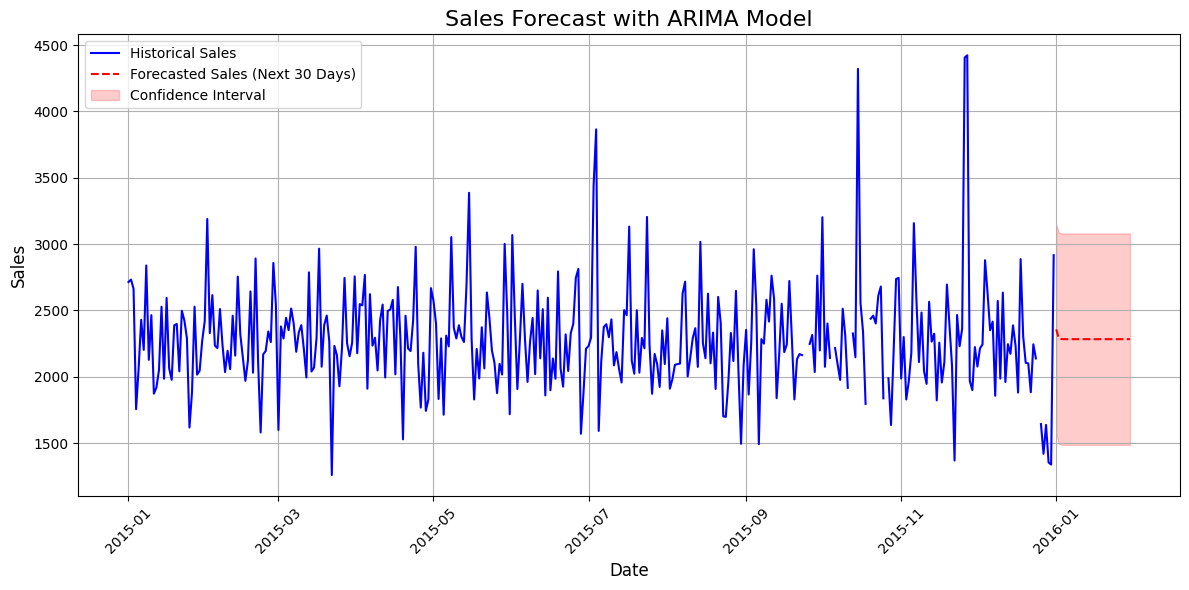

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Plot the historical time series data
plt.figure(figsize=(12, 6))

# Vẽ chuỗi thời gian gốc
plt.plot(time_series.index, time_series, label='Historical Sales', color='blue')

# Step 2: Plot the forecasted values
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecasted Sales (Next 30 Days)', color='red', linestyle='--')

# Step 3: Plot the confidence interval for the forecast
plt.fill_between(forecast_df['Date'], forecast_df['Lower Bound'], forecast_df['Upper Bound'],
                 color='red', alpha=0.2, label='Confidence Interval')

# Step 4: Customize the plot
plt.title('Sales Forecast with ARIMA Model', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()

# Show the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1.3. Forecasting revenue for each day of the next year from the end of the last day of 2015 using ARIMA (AutoRegressive Integrated Moving Average) model

In [ ]:
import pandas as pd

# Đọc dữ liệu từ file Excel đã cung cấp
data = pd.read_excel('/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales.xlsx')

# Chuyển đổi dữ liệu thành chuỗi thời gian
# Giả sử cột 'order_date' chứa ngày và 'total_price' là tổng doanh số
data['order_date'] = pd.to_datetime(data['order_date'])
time_series = data.groupby('order_date')['total_price'].sum()

# Đảm bảo index là kiểu datetime và tần suất hàng ngày
time_series.index = pd.to_datetime(time_series.index)
time_series = time_series.asfreq('D')  # Gắn tần suất là hàng ngày


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Kiểm tra tính dừng của chuỗi thời gian
adf_test = adfuller(time_series.dropna())  # Loại bỏ NaN trước khi kiểm tra
if adf_test[1] > 0.05:
    print("Chuỗi không dừng, cần làm sai phân.")
    time_series_diff = time_series.diff().dropna()  # Sai phân bậc 1
else:
    print("Chuỗi đã dừng, không cần làm sai phân.")
    time_series_diff = time_series  # Sử dụng chuỗi gốc

# Huấn luyện mô hình ARIMA
model = ARIMA(time_series_diff, order=(1, 1, 1))  # Điều chỉnh (p, d, q) nếu cần
model_fit = model.fit()

# Dự báo 1 năm (365 ngày)
forecast_steps = 365
forecast = model_fit.get_forecast(steps=forecast_steps)

# Tạo index cho kết quả dự báo
forecast_index = pd.date_range(start=time_series.index[-1] + pd.Timedelta(days=1),
                               periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Kết quả dự báo trong DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_values.values,
    'Lower Bound': forecast_conf_int.iloc[:, 0].values,
    'Upper Bound': forecast_conf_int.iloc[:, 1].values
})

print(forecast_df)


Chuỗi đã dừng, không cần làm sai phân.
          Date     Forecast  Lower Bound  Upper Bound
0   2016-01-01  2357.491626  1566.712330  3148.270922
1   2016-01-02  2291.810941  1495.326336  3088.295545
2   2016-01-03  2284.086880  1487.493571  3080.680189
3   2016-01-04  2283.178529  1486.580178  3079.776880
4   2016-01-05  2283.071707  1486.472870  3079.670544
..         ...          ...          ...          ...
360 2016-12-26  2283.057470  1486.458567  3079.656374
361 2016-12-27  2283.057470  1486.458567  3079.656374
362 2016-12-28  2283.057470  1486.458567  3079.656374
363 2016-12-29  2283.057470  1486.458567  3079.656374
364 2016-12-30  2283.057470  1486.458567  3079.656374

[365 rows x 4 columns]


In [ ]:
# Hiển thị 10 dòng đầu tiên của kết quả
print(forecast_df.head(10))

# Lưu dự báo vào file CSV
forecast_df.to_csv('sales_forecast_1_year.csv', index=False)
print("Kết quả đã lưu vào 'sales_forecast_1_year.csv'")


        Date     Forecast  Lower Bound  Upper Bound
0 2016-01-01  2357.491626  1566.712330  3148.270922
1 2016-01-02  2291.810941  1495.326336  3088.295545
2 2016-01-03  2284.086880  1487.493571  3080.680189
3 2016-01-04  2283.178529  1486.580178  3079.776880
4 2016-01-05  2283.071707  1486.472870  3079.670544
5 2016-01-06  2283.059145  1486.460252  3079.658037
6 2016-01-07  2283.057667  1486.458768  3079.656566
7 2016-01-08  2283.057494  1486.458594  3079.656393
8 2016-01-09  2283.057473  1486.458573  3079.656373
9 2016-01-10  2283.057471  1486.458571  3079.656370
Kết quả đã lưu vào 'sales_forecast_1_year.csv'


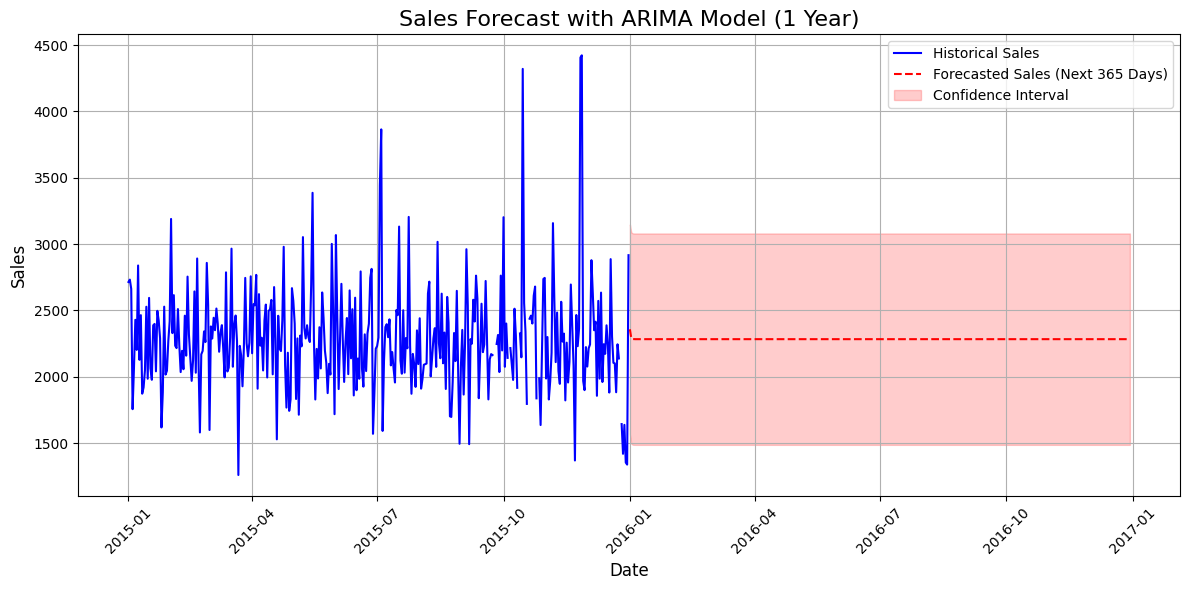

In [ ]:
import matplotlib.pyplot as plt

# Vẽ chuỗi thời gian gốc
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu bán hàng lịch sử
plt.plot(time_series.index, time_series, label='Historical Sales', color='blue')

# Vẽ các giá trị dự báo
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecasted Sales (Next 365 Days)', color='red', linestyle='--')

# Vẽ khoảng tin cậy
plt.fill_between(forecast_df['Date'], forecast_df['Lower Bound'], forecast_df['Upper Bound'],
                 color='red', alpha=0.2, label='Confidence Interval')

# Tùy chỉnh biểu đồ
plt.title('Sales Forecast with ARIMA Model (1 Year)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# V/ Gradient Boosting Regressor (bỏ)

1.4. Forecasting revenue for each pizza for the next 30 days from the end of the last day of 2015 using Gradient Boosting Regressor model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Bước 1: Đọc dữ liệu
data = pd.read_excel('/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales.xlsx')

# Bước 2: Chuẩn bị dữ liệu
# Phân rã order_date thành các đặc trưng ngày, tháng, ngày trong tuần
data['order_date'] = pd.to_datetime(data['order_date'])
data['day'] = data['order_date'].dt.day
data['month'] = data['order_date'].dt.month
data['year'] = data['order_date'].dt.year
data['day_of_week'] = data['order_date'].dt.dayofweek

# Tạo biến lag (doanh số ngày trước đó)
data = data.sort_values(['pizza_name', 'order_date'])
data['lag_1'] = data.groupby('pizza_name')['total_price'].shift(1)

# Loại bỏ các giá trị NaN (phát sinh từ lag)
data = data.dropna()

# One-hot encoding cho cột pizza_name
data = pd.get_dummies(data, columns=['pizza_name'], drop_first=True)

# Chọn đặc trưng đầu vào (features) và nhãn (label)
X = data[['day', 'month', 'day_of_week', 'lag_1'] + list(data.columns[data.columns.str.startswith('pizza_name_')])]
y = data['total_price']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 3: Huấn luyện mô hình hồi quy (Gradient Boosting)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Bước 4: Dự báo doanh số 30 ngày tới cho từng loại pizza
future_dates = pd.date_range(start=data['order_date'].max() + pd.Timedelta(days=1),
                             periods=30, freq='D')
future_df = pd.DataFrame({
    'day': future_dates.day,
    'month': future_dates.month,
    'day_of_week': future_dates.dayofweek,
    'lag_1': y.tail(1).values[0],  # Sử dụng giá trị cuối cùng làm lag_1
})

# Thêm các cột pizza_name đã mã hóa
for col in X.columns:
    if col.startswith('pizza_name_'):
        future_df[col] = 0  # Đặt giá trị ban đầu là 0 (giả định cho từng loại)

# Dự báo doanh số cho từng loại pizza
results = {}
pizza_columns = [col for col in X.columns if col.startswith('pizza_name_')]
for pizza_col in pizza_columns:
    future_df[pizza_col] = 1  # Đặt loại pizza hiện tại
    predictions = model.predict(future_df)
    results[pizza_col] = predictions
    future_df[pizza_col] = 0  # Reset sau mỗi lần dự báo

# Chuyển kết quả thành DataFrame để dễ xem
results_df = pd.DataFrame(results, index=future_dates)
results_df.index.name = 'Date'

print(results_df.head(10))

MSE: 15.458729105349278
MAE: 2.8138576377445585
            pizza_name_The Big Meat Pizza  pizza_name_The Brie Carre Pizza  \
Date                                                                         
2016-01-01                      13.502698                        22.908731   
2016-01-02                      13.502698                        22.908731   
2016-01-03                      13.502698                        23.436833   
2016-01-04                      13.502698                        23.033523   
2016-01-05                      13.502698                        23.033523   
2016-01-06                      13.502698                        23.033523   
2016-01-07                      13.502698                        23.209883   
2016-01-08                      13.183947                        23.128969   
2016-01-09                      13.183947                        23.001926   
2016-01-10                      13.183947                        23.001926   

            piz

In [ ]:
results_df.to_csv('pizza_sales_forecast_30_days.csv')
print("Kết quả đã lưu vào 'pizza_sales_forecast_30_days.csv'")

Kết quả đã lưu vào 'pizza_sales_forecast_30_days.csv'


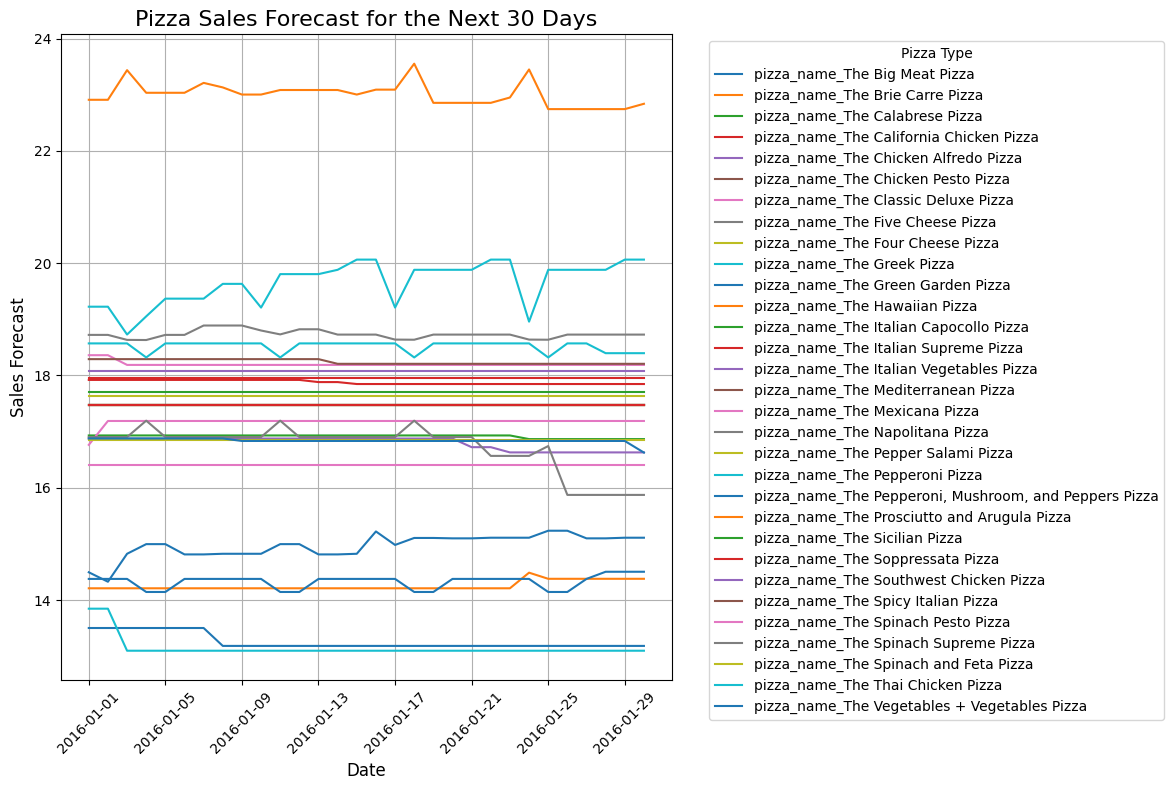

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ dự báo cho từng loại pizza
plt.figure(figsize=(12, 8))

# Duyệt qua các loại pizza và vẽ biểu đồ
for pizza_col in results_df.columns:
    plt.plot(results_df.index, results_df[pizza_col], label=pizza_col)

# Tùy chỉnh biểu đồ
plt.title('Pizza Sales Forecast for the Next 30 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Forecast', fontsize=12)
plt.legend(title='Pizza Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


1.5. Forecasting revenue for each pizza for each day of the next year from the end of the last day of 2015 using Gradient Boosting Regressor model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Bước 1: Đọc dữ liệu
data = pd.read_excel('/content/drive/MyDrive/BI_FinalProject_Semester1_2024_2025/Processed_Pizza_Sales.xlsx')

# Bước 2: Chuẩn bị dữ liệu
# Phân rã order_date thành các đặc trưng ngày, tháng, ngày trong tuần
data['order_date'] = pd.to_datetime(data['order_date'])
data['day'] = data['order_date'].dt.day
data['month'] = data['order_date'].dt.month
data['year'] = data['order_date'].dt.year
data['day_of_week'] = data['order_date'].dt.dayofweek

# Tạo biến lag (doanh số ngày trước đó)
data = data.sort_values(['pizza_name', 'order_date'])
data['lag_1'] = data.groupby('pizza_name')['total_price'].shift(1)

# Loại bỏ các giá trị NaN (phát sinh từ lag)
data = data.dropna()

# One-hot encoding cho cột pizza_name
data = pd.get_dummies(data, columns=['pizza_name'], drop_first=True)

# Chọn đặc trưng đầu vào (features) và nhãn (label)
X = data[['day', 'month', 'day_of_week', 'lag_1'] + list(data.columns[data.columns.str.startswith('pizza_name_')])]
y = data['total_price']

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bước 3: Huấn luyện mô hình hồi quy (Gradient Boosting)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Bước 4: Dự báo doanh số 365 ngày tới cho từng loại pizza
future_dates = pd.date_range(start=data['order_date'].max() + pd.Timedelta(days=1),
                             periods=365, freq='D')
future_df = pd.DataFrame({
    'day': future_dates.day,
    'month': future_dates.month,
    'day_of_week': future_dates.dayofweek,
    'lag_1': y.tail(1).values[0],  # Sử dụng giá trị cuối cùng làm lag_1
})

# Thêm các cột pizza_name đã mã hóa
for col in X.columns:
    if col.startswith('pizza_name_'):
        future_df[col] = 0  # Đặt giá trị ban đầu là 0 (giả định cho từng loại)

# Dự báo doanh số cho từng loại pizza
results = {}
pizza_columns = [col for col in X.columns if col.startswith('pizza_name_')]
for pizza_col in pizza_columns:
    future_df[pizza_col] = 1  # Đặt loại pizza hiện tại
    predictions = model.predict(future_df)
    results[pizza_col] = predictions
    future_df[pizza_col] = 0  # Reset sau mỗi lần dự báo

# Chuyển kết quả thành DataFrame để dễ xem
results_df = pd.DataFrame(results, index=future_dates)
results_df.index.name = 'Date'

print(results_df.head(10))

MSE: 15.458729105349278
MAE: 2.8138576377445585
            pizza_name_The Big Meat Pizza  pizza_name_The Brie Carre Pizza  \
Date                                                                         
2016-01-01                      13.502698                        22.908731   
2016-01-02                      13.502698                        22.908731   
2016-01-03                      13.502698                        23.436833   
2016-01-04                      13.502698                        23.033523   
2016-01-05                      13.502698                        23.033523   
2016-01-06                      13.502698                        23.033523   
2016-01-07                      13.502698                        23.209883   
2016-01-08                      13.183947                        23.128969   
2016-01-09                      13.183947                        23.001926   
2016-01-10                      13.183947                        23.001926   

            piz

In [ ]:
results_df.to_csv('pizza_sales_forecast_365_days.csv')
print("Kết quả đã lưu vào 'pizza_sales_forecast_365_days.csv'")

Kết quả đã lưu vào 'pizza_sales_forecast_365_days.csv'


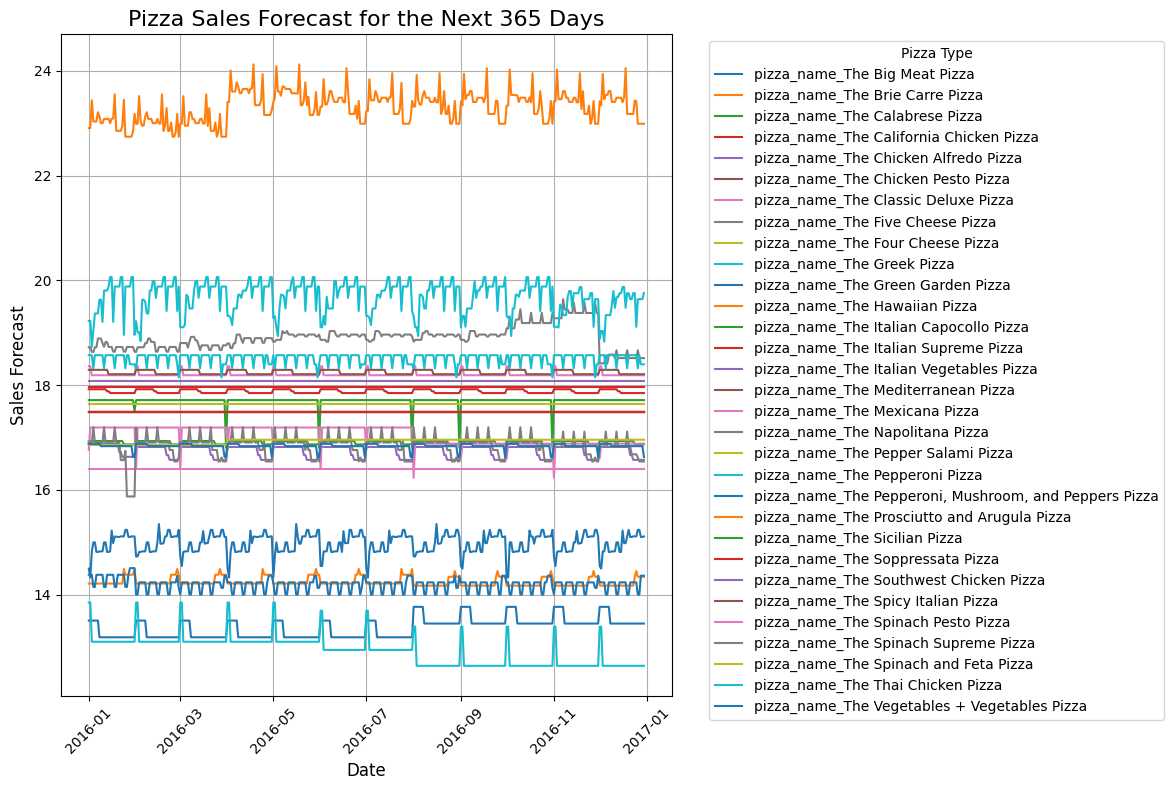

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ dự báo cho từng loại pizza
plt.figure(figsize=(12, 8))

# Duyệt qua các loại pizza và vẽ biểu đồ
for pizza_col in results_df.columns:
    plt.plot(results_df.index, results_df[pizza_col], label=pizza_col)

# Tùy chỉnh biểu đồ
plt.title('Pizza Sales Forecast for the Next 365 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Forecast', fontsize=12)
plt.legend(title='Pizza Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
